In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

In [3]:
# Important imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from tensorflow import keras
from sklearn.preprocessing import  LabelBinarizer
from keras.preprocessing import image
from keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU
from sklearn.model_selection import train_test_split

In [4]:
# Listing directory
!ls "/content/drive/My Drive/Intel Image Dataset"

buildings  forest  glacier  mountain  sea  street


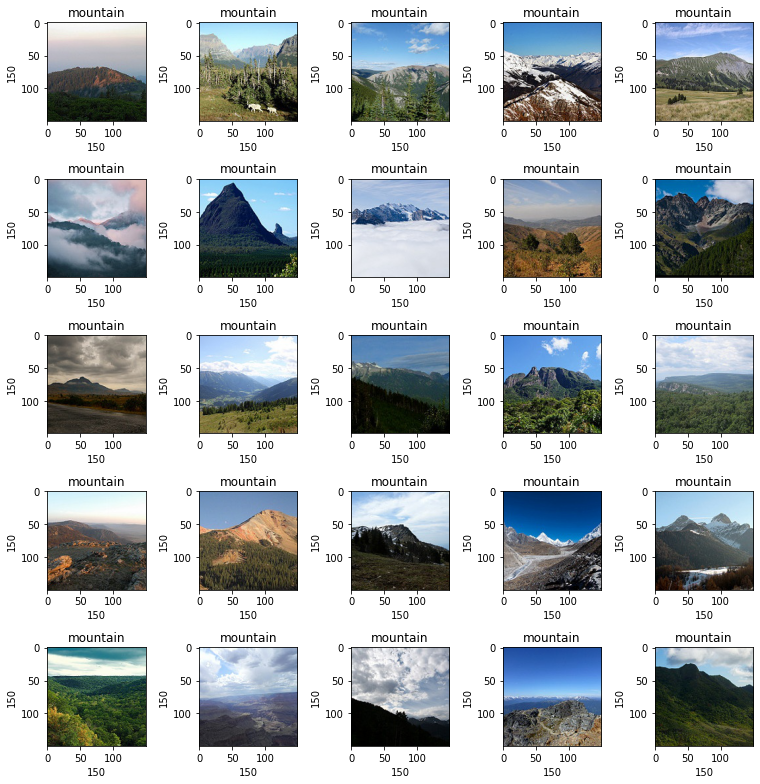

In [5]:
# Plotting 25 images to check dataset
plt.figure(figsize=(11,11))
path = "/content/drive/My Drive/Intel Image Dataset/mountain"
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(listdir(path))))
    plt.imshow(rand_img)
    plt.title('mountain')
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

In [6]:
# Setting root directory path and creating empty list
dir = "/content/drive/My Drive/Intel Image Dataset"
root_dir = listdir(dir)
image_list, label_list = [], []

In [7]:
# Reading and converting image to numpy array
for directory in root_dir:
  for files in listdir(f"{dir}/{directory}"):
    image_path = f"{dir}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((150,150)) # All images does not have same dimension
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

In [8]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

glacier      553
mountain     525
sea          510
street       501
forest       474
buildings    437
dtype: int64

In [9]:
# Checking count of classes
num_classes = len(label_counts)
num_classes

6

In [10]:
# Checking x data shape
np.array(image_list).shape

(3000, 150, 150, 3)

In [11]:
# Checking y data shape
label_list = np.array(label_list)
label_list.shape

(3000,)

In [12]:
# Splitting dataset into test and train
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

In [13]:
# Normalize and reshape data
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 150,150,3)
x_test = x_test.reshape( -1, 150,150,3)

In [14]:
# Binarizing labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [15]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [16]:
# Creating model architecture
model = Sequential([
        Conv2D(16, kernel_size = (3,3), input_shape = (150,150,3)),
        BatchNormalization(),
        LeakyReLU(),
          
        Conv2D(32, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),
        
        Conv2D(64, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2D(128, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),

        Flatten(),
    
        Dense(64),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
        
        Dense(32),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
    
        Dense(16),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(1),
    
        Dense(6, activation = 'softmax')    
        ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 148, 148, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 146, 146, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 146, 146, 32)      0

ตอนนี้เราจะสร้างสถาปัตยกรรมเครือข่ายสำหรับโมเดล เราใช้เลเยอร์ประเภทต่างๆ ตามคุณลักษณะ ได้แก่ BatchNormalization (Batch Normalization เป็นเทคนิคสำหรับการฝึกโครงข่ายประสาทเทียมระดับลึกมากซึ่งกำหนดมาตรฐานอินพุตให้กับเลเยอร์สำหรับแต่ละแบทช์ขนาดเล็ก), LeakyRelu (Leaky ReLU แก้ไขฟังก์ชันเพื่อให้มีขนาดเล็ก ค่าลบเมื่ออินพุตมีค่าน้อยกว่าศูนย์), Conv_2d (ใช้เพื่อสร้างเคอร์เนล convolutional ที่รวมเข้ากับเลเยอร์อินพุตเพื่อสร้างเอาต์พุตเทนเซอร์), max_pooling2d (เป็นเทคนิคการสุ่มตัวอย่างซึ่งจะดึงค่าสูงสุดออกจาก หน้าต่างที่กำหนดโดย poolsize), แบน (แบนอินพุตและสร้างเอาต์พุต 1D), หนาแน่น (เลเยอร์หนาแน่นสร้างเอาต์พุตเป็นผลิตภัณฑ์ดอทของอินพุตและเคอร์เนล) ในเลเยอร์สุดท้าย เราจะใช้ softmax เป็นฟังก์ชันการเปิดใช้งานเนื่องจากเป็นปัญหาการจำแนกประเภทหลายคลาส

In [17]:
# Compiling model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])

ในการคอมไพล์โมเดล เราจำเป็นต้องผ่านพารามิเตอร์ 3 ตัว ได้แก่ ค่าสูญเสีย ตัวเพิ่มประสิทธิภาพ และเมตริก ที่นี่เราจะใช้การสูญเสียเป็น categorical_crossentropy เครื่องมือเพิ่มประสิทธิภาพเป็น Adam และเมตริกเป็นความแม่นยำ

In [18]:
# Training the model
epochs = 100
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/100
15/15 [==============================] - 8s 212ms/step - loss: 1.6260 - accuracy: 0.3703 - val_loss: 1.8033 - val_accuracy: 0.1708
Epoch 2/100
15/15 [==============================] - 2s 148ms/step - loss: 1.2615 - accuracy: 0.5401 - val_loss: 1.9403 - val_accuracy: 0.1813
Epoch 3/100
15/15 [==============================] - 2s 148ms/step - loss: 1.1091 - accuracy: 0.6031 - val_loss: 2.0391 - val_accuracy: 0.2625
Epoch 4/100
15/15 [==============================] - 2s 150ms/step - loss: 0.9853 - accuracy: 0.6656 - val_loss: 2.1797 - val_accuracy: 0.1437
Epoch 5/100
15/15 [==============================] - 2s 148ms/step - loss: 0.8895 - accuracy: 0.7005 - val_loss: 2.2628 - val_accuracy: 0.1437
Epoch 6/100
15/15 [==============================] - 2s 149ms/step - loss: 0.7850 - accuracy: 0.7458 - val_loss: 2.3104 - val_accuracy: 0.1437
Epoch 7/100
15/15 [==============================] - 2s 149ms/step - loss: 0.7077 - accuracy: 0.7911 - val_loss: 2.2636 - val_accuracy: 0.1479

ปรับโมเดลให้เข้ากับข้อมูลและค้นหาความแม่นยำในแต่ละยุคเพื่อดูว่าโมเดลของเราเรียนรู้อย่างไร ตอนนี้เราจะฝึกโมเดลของเราใน 100 ยุคและขนาดชุดที่ 128 คุณสามารถลองใช้จำนวนยุคมากขึ้นเพื่อเพิ่มความแม่นยำ ในแต่ละยุค เราสามารถเห็นประสิทธิภาพของโมเดลโดยการดูการฝึกอบรมและการตรวจสอบความถูกต้อง

In [19]:
# Saving model
model.save("/content/drive/My Drive/intel_image.h5")

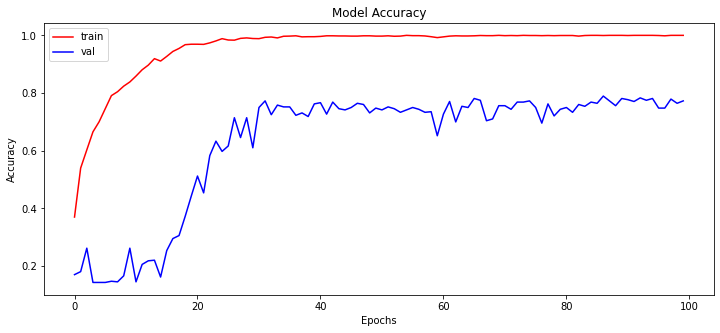

In [20]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

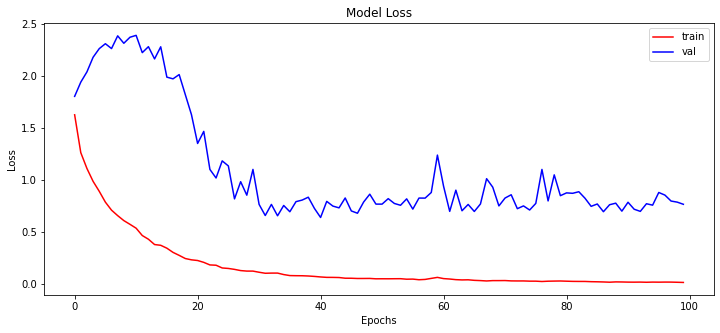

In [21]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [22]:
# Calculating test accuracy 
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

19/19 [==============================] - 1s 22ms/step - loss: 0.9372 - accuracy: 0.7350
Test Accuracy: 73.50000143051147


In [23]:
# Storing model predictions
y_pred = model.predict(x_test)

19/19 [==============================] - 0s 11ms/step


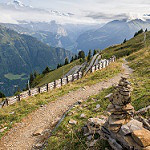

In [24]:
# Plotting image to compare
img = array_to_img(x_test[1])
img

In [25]:
# Finding max value from predition list and comaparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[1])])
print("Predicted : ",labels[np.argmax(y_pred[1])])

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Originally :  mountain
Predicted :  mountain


## Conclusion:

ในโครงการนี้เราได้เห็นว่าเราสามารถสร้าง CNN โดยใช้เลเยอร์ต่างๆ ได้อย่างไร การทำให้เป็นมาตรฐานเป็นขั้นตอนสำคัญเมื่อทำงานกับชุดข้อมูลทุกประเภท เราจะใช้โมเดลนี้เพื่อทำนายคลาสของภาพที่ป้อนให้กับโมเดล

## Scope:

โครงการนี้มีขอบเขตกว้างขวางสามารถใช้จำแนกภาพถ่ายดาวเทียม ภาพโดรน ภาพ Google ออกเป็นประเภทต่างๆ เช่น ทะเล ภูเขา ฯลฯ